In [1]:
setwd('/import/DB/fel/BJTC-204')

In [2]:
load('/import/mdd.rna/GSE80655.rda')

In [10]:
ls()

[1] "cliinfo" "expr3"

In [11]:
library(BayesPrism)

In [12]:
sce = readRDS('../final.rds')

In [13]:
table(sce$celltype)

Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.2.3"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)




  Ast   End   ExN   InN   Mic   Mix   OPC   Oli 
13210  3948 77458 28336  3744  3800  7678 22537 

In [14]:
Idents(sce) = 'celltype'
sce1 = subset(sce,idents = c('Ast',   'End',   'ExN',   'InN',   'Mic',     'OPC',   'Oli'))

In [15]:
table(sce1$celltype)


  Ast   End   ExN   InN   Mic   Mix   OPC   Oli 
13210  3948 77458 28336  3744     0  7678 22537 

In [16]:
sce = sce1

In [17]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"


In [18]:
Idents(sce) <- "celltype"
# Downsample the number of cells per identity class
sm1 <- subset(x = sce, downsample = 50000)
count = as.matrix(sm1@assays$RNA@counts)
sc.dat = t(count)

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 32.4 GiB"


In [19]:
cell.type.labels <- sm1@meta.data[["celltype"]]
#cell.state.labels <- sm1@meta.data[["subcluster"]]

In [20]:
plot.cor.phi (input=sc.dat, 
                         input.labels=cell.type.labels, 
                         title="cell type correlation",
                         #specify pdf.prefix if need to output to pdf
                         pdf.prefix="gbm.cor.ct",
                         cexRow=0.5, cexCol=0.5,
                         )

png 
  2

In [21]:
sc.stat <- plot.scRNA.outlier(
  input=sc.dat, #make sure the colnames are gene symbol or ENSMEBL ID 
  cell.type.labels=cell.type.labels,
  species="hs", #currently only human(hs) and mouse(mm) annotations are supported
  return.raw=TRUE ,#return the data used for plotting. 
  pdf.prefix="gbm.sc.stat" #specify pdf.prefix if need to output to pdf
)
head(sc.stat)     

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.


,exp.mean.log,max.spec,other_Rb,chrM,chrX,chrY,Rb,Mrp,act,hb,MALAT1
,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
MIR1302-2HG,-16.69848,0.4591409,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
AL627309.1,-13.45281,0.2996983,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
AL627309.3,-16.40122,0.3049916,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
AL627309.5,-12.04677,0.3098530,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
AL627309.4,-17.46616,0.5340698,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
AP006222.2,-16.37929,0.3263344,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [22]:
library(dplyr)


Attaching package: 'dplyr'


The following object is masked from 'package:Biobase':

    combine


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [23]:
rownames(expr3) = expr3[,1]

In [24]:
expr3 = expr3[,-1]

In [25]:
bk.dat = expr3

In [26]:
bk.dat = t(bk.dat)
bk.stat <- plot.bulk.outlier(
  bulk.input=bk.dat,#make sure the colnames are gene symbol or ENSMEBL ID 
    sc.input=sc.dat, #make sure the colnames are gene symbol or ENSMEBL ID 
  cell.type.labels=cell.type.labels,
  species="hs", #currently only human(hs) and mouse(mm) annotations are supported
  return.raw=TRUE,
  pdf.prefix="gbm.bk.stat" #specify pdf.prefix if need to output to pdf
)

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.


In [27]:
sc.dat.filtered <- cleanup.genes (input=sc.dat,
                                  input.type="count.matrix",
                                    species="hs", 
                                    gene.group=c( "Rb","Mrp","other_Rb","chrM",
"MALAT1","chrX","chrY","hb","act"),
                                    exp.cells=5)
plot.bulk.vs.sc (sc.input = sc.dat.filtered,
                 bulk.input = bk.dat,
                 pdf.prefix="gbm.bk.vs.sc" #specify pdf.prefix if need to output to pdf
                 )

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.
number of genes filtered in each category: 
      Rb      Mrp other_Rb     chrM   MALAT1     chrX     chrY       hb 
      89       78       20        0        1     1016       78       10 
     act 
       6 
A total of  1257  genes from Rb Mrp other_Rb chrM MALAT1 chrX chrY hb act  have been excluded 
A total of  873  gene expressed in fewer than  5  cells have been excluded 
Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.


In [28]:
sc.dat.filtered.pc <-  select.gene.type (sc.dat.filtered,
                                         gene.type = "protein_coding")
                                         
## 这里都用的大类，才没报错                                     
myPrism <- new.prism(
  reference=sc.dat.filtered.pc, 
  mixture=bk.dat,
  input.type="count.matrix", 
  cell.type.labels = cell.type.labels, 
  cell.state.labels = cell.type.labels,
  key=NULL,# 
  outlier.cut=0.01,
  outlier.fraction=0.1,
)     
bp.res <- run.prism(prism = myPrism, n.cores=40)
slotNames(bp.res)

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.
number of genes retained in each category: 

protein_coding 
         16426 
number of cells in each cell state 
cell.state.labels
  Mic   End   OPC   Ast   Oli   InN   ExN 
 3744  3948  7678 13210 22537 28336 50000 
No tumor reference is speficied. Reference cell types are treated equally. 


Warning message in validate.input(reference):
"Warning: input seems to be log-transformed. Please double check your input. Log transformation should be avoided"


Number of outlier genes filtered from mixture = 7 
Aligning reference and mixture... 
Normalizing reference... 
Run Gibbs sampling... 
Current time:  2024-09-02 06:01:15 
Estimated time to complete:  7mins 
Estimated finishing time:  2024-09-02 06:07:18 
Start run... 
R Version:  R version 4.2.1 (2022-06-23) 



snowfall 1.84-6.3 initialized (using snow 0.4-4): parallel execution on 40 CPUs.



Stopping cluster




Update the reference matrix ... 


snowfall 1.84-6.3 initialized (using snow 0.4-4): parallel execution on 40 CPUs.



Stopping cluster




Run Gibbs sampling using updated reference ... 
Current time:  2024-09-02 06:05:43 
Estimated time to complete:  9mins 
Estimated finishing time:  2024-09-02 06:13:59 
Start run... 


snowfall 1.84-6.3 initialized (using snow 0.4-4): parallel execution on 40 CPUs.



Stopping cluster




[1] "prism"                       "posterior.initial.cellState"
[3] "posterior.initial.cellType"  "reference.update"           
[5] "posterior.theta_f"           "control_param"

In [29]:
save(bp.res, file="bys1.remove.res.rdata")
theta <- get.fraction(bp=bp.res,
                       which.theta="final",
                       state.or.type="type")
write.csv(theta,file="bys1-removemix.csv")            

In [3]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
theta = read.csv('./bys1-removemix.csv',row.names = 1)

In [5]:
end = theta %>%  as.data.frame() %>%  tibble::rownames_to_column(.,'sample')

In [6]:
colnames(cliinfo) = c('sample','age','Condition','sex','id','local')

In [7]:
dataset = merge(cliinfo,end,by = 'sample')

In [8]:
head(dataset,3)

,sample,age,Condition,sex,id,local,Mic,ExN,InN,Oli,Ast,OPC,End
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SL32230,48,MD,F,X3004,DLPFC,5.180164e-07,0.9045109,2.806284e-06,1.204192e-06,0.04933491,5.418089e-07,0.04614911
2,SL32231,46,MD,M,X3064,DLPFC,2.409669e-03,0.8639261,2.739055e-05,4.220033e-02,0.04040271,6.863051e-06,0.05102690
3,SL32242,32,Control,M,X3186,DLPFC,1.925752e-06,0.8311301,1.417429e-06,9.698113e-02,0.03019750,2.754183e-07,0.04168762


In [9]:
my_comparisons = list(c('Control','MD'))

In [10]:
library(ggpubr)

Warning message:
"package 'ggpubr' was built under R version 4.2.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


In [11]:
options(repr.plot.height = 8.5,repr.plot.width = 8)

Warning message in .check_data(data, x, y, combine = combine | merge != "none"):
"Can't find the following element in the data: NA"


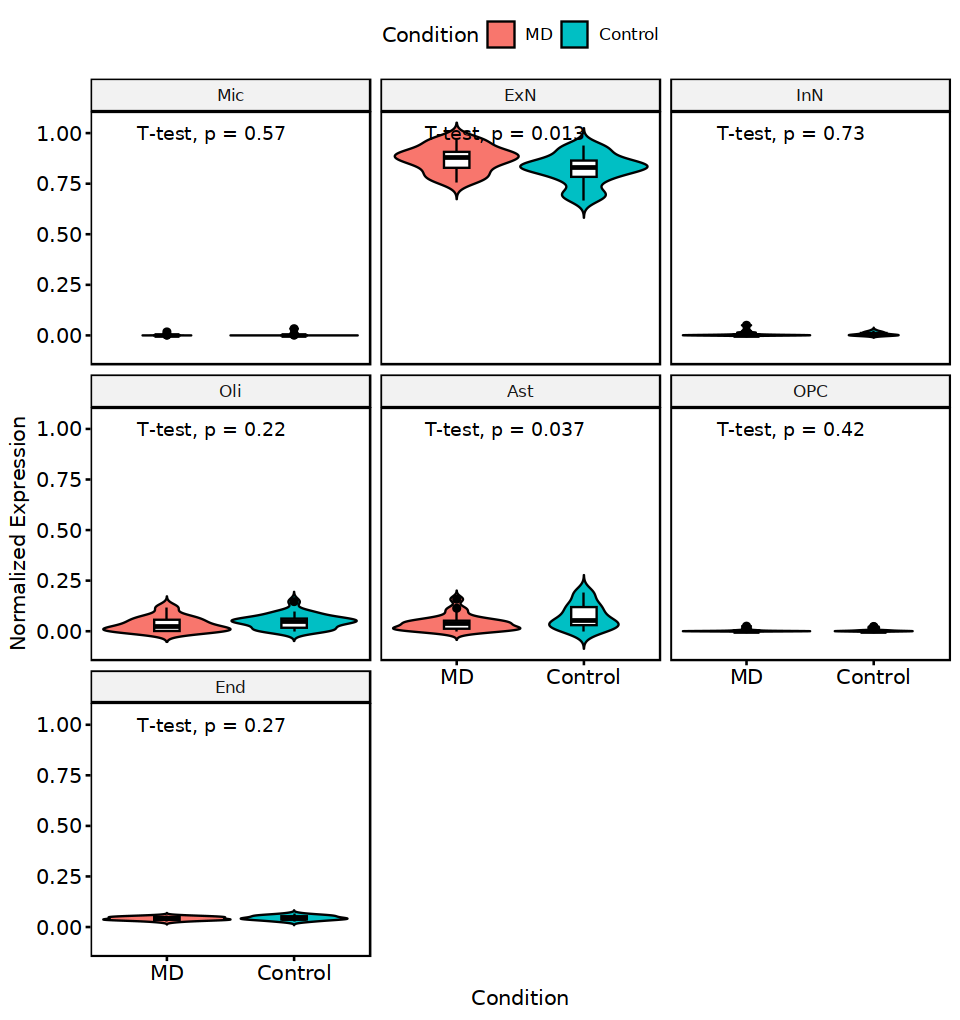

In [13]:
dataset %>% 
  #dplyr::filter(group %in% c("IBC","N","DCIS")) %>% 
  ggviolin(x = "Condition", y = c(colnames(dataset)[7:14]), fill = "Condition",
           combine = T,
         #palette = c("#00AFBB", "#E7B800", "#FC4E07"),##
         ylab="Normalized Expression",
         add = "boxplot", add.params = list(fill = "white"))+
stat_compare_means(method = 't.test')

In [ ]:
ggsave('violin_plot1.remove.pdf',height = 10,width = 8)